In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
noiseVariancedBm = -96
fc = 2e9
N = 1 # number of antennas
sigma_sf = 8

#Height of BS (in meters)
h_BS = 10
#Height of UT (in meters)
h_UT = 1.5
#shadow fading decorrelation distance of 13m for both 3GPP-3D-UMi and 3GPP-38.901-UMi
decorr = 8

squareLength = 200 #each side of a square simulation area
#minimum distance between BSs and UEs
minDistanceUE2AP = 5.5 # (d2D > 5.5) => (d3D > 10m) for h_UT = 1.5m and h_BS = 10m
minDistanceAP2AP = 20
L = 25 #total number of APs in simulation area
RP_SIM_TYPE = 1 #whether there are 4 RP in RPS or 6 RP
RP_positions_per_row = 10
K = RP_positions_per_row**2 #number of fingerprint positions
num_tp_points = 1000
nbrOfSetups = 1

In [ ]:
def cell_free_layout_setup(RP_positions_per_row, squareLength, minDistanceUE2AP, num_tp_points):
    inter_RP_dist = squareLength / (RP_positions_per_row - 1)  # 1000/20 => each RP spaced apart by 50
    RP_positions_x = np.arange(1, RP_positions_per_row+1)
    RP_positions_y = np.arange(1, RP_positions_per_row+1)
    RP_positions_X, RP_positions_Y = np.meshgrid(RP_positions_x, RP_positions_y)
    RP_positions_X = (RP_positions_X - 1) * inter_RP_dist
    RP_positions_Y = (RP_positions_Y - 1) * inter_RP_dist
    RP_positions = RP_positions_X + 1j * RP_positions_Y
    RP_positions = RP_positions.T

    #AP_positions = RP_positions + (inter_RP_dist/2)*(1+1j) #AP placed at centre of the subregion
    #AP_positions = AP_positions[0:(RP_positions_per_row-1),0:(RP_positions_per_row-1)]

    # Combine x and y coordinates to get complex coordinates

    AP_positions = np.array([10+10j, 55+10j, 100+10j, 145+10j, 190+10j,
                             10+55j, 55+55j, 100+55j, 145+55j, 190+55j,
                             10+100j, 55+100j, 100+100j, 145+100j, 190+100j,
                             10+145j, 55+145j, 100+145j, 145+145j, 190+145j,
                             10+190j, 55+190j, 100+190j, 145+190j, 190+190j])
    '''
    # Random AP locations with uniform distribution
    for AP_idx in range(L):
        AP_pos_rand = (np.random.rand() + 1j * np.random.rand()) * squareLength
        # if the dist is less than 10m between any two APs or RP positions and any AP then reposition the AP
        while (np.min(np.abs(RP_positions - AP_pos_rand)) < minDistanceUE2AP) or \
              (np.min(np.abs(AP_positions - AP_pos_rand)) < minDistanceAP2AP):
            AP_pos_rand = (np.random.rand() + 1j * np.random.rand()) * squareLength
        AP_positions[AP_idx] = AP_pos_rand
    AP_positions
    '''
    TP_positions = np.zeros(num_tp_points, dtype=complex)
    for TP_idx in range(num_tp_points):
        TP_pos_rand = (np.random.rand() + 1j * np.random.rand()) * squareLength
        while np.min(np.abs(AP_positions - TP_pos_rand)) < minDistanceUE2AP:
            TP_pos_rand = (np.random.rand() + 1j * np.random.rand()) * squareLength
        TP_positions[TP_idx] = TP_pos_rand
    TP_positions
    return RP_positions.flatten(), TP_positions, AP_positions.flatten()

In [ ]:
def function_plot_setup(squareLength, RP_positions, AP_positions, TP_positions=None):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot grid lines
    grid_spacing = 100
    ax.set_xticks(np.arange(0, squareLength + 1, grid_spacing))
    ax.set_yticks(np.arange(0, squareLength + 1, grid_spacing))
    ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray')

    # Plot RP positions
    ax.plot(np.real(RP_positions), np.imag(RP_positions), 'xb', markersize=7, label='RP Positions')

    # Plot AP positions
    ax.plot(np.real(AP_positions), np.imag(AP_positions), '^r', markersize=10, label='AP Positions')

    # Plot TP positions if provided
    if TP_positions is not None and len(TP_positions) > 0:
        ax.plot(np.real(TP_positions), np.imag(TP_positions), 'og', markersize=7, label='TP Positions')

    ax.set_title('Positioning Simulation Setup')
    ax.set_xlabel('Horizontal Distance (m)')
    ax.set_ylabel('Vertical Distance (m)')

    # Extend the plot boundaries with padding
    padding = 50
    ax.set_xlim([-padding, squareLength + padding])
    ax.set_ylim([-padding, squareLength + padding])
    ax.legend(loc='upper left')
    plt.show()

In [ ]:
[RP_positions,TP_positions,AP_positions] = cell_free_layout_setup(RP_positions_per_row, squareLength, minDistanceUE2AP, num_tp_points)

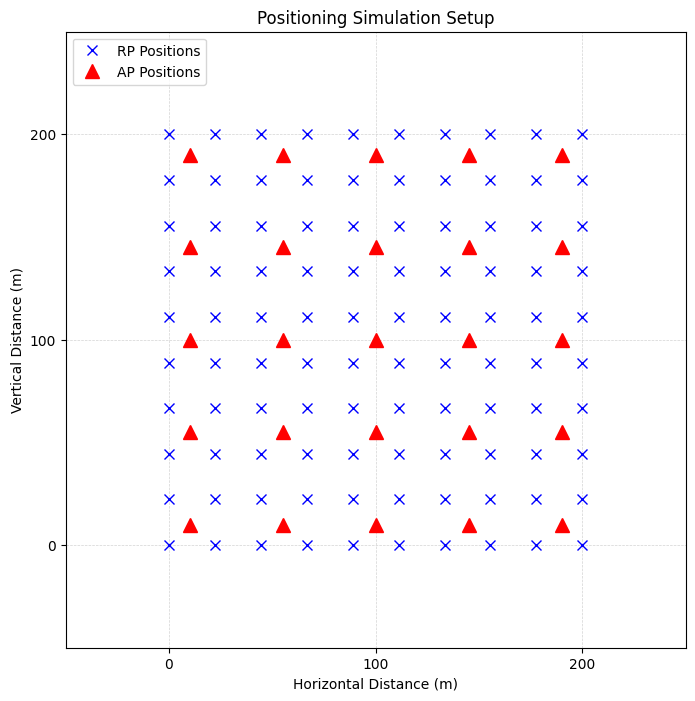

In [ ]:
function_plot_setup(squareLength, RP_positions, AP_positions)

In [ ]:
def db2pow(xdb):
    return 10**(xdb/10)

In [ ]:
import numpy as np

p = 100
tau_p = 1
beta_fngprnt = np.zeros((K, L))
RSS_fngprnt_mW = np.zeros((K, L))

for setup_idx in range(1, nbrOfSetups + 1):
    #print("setup_idx : ", setup_idx)
    beta_fngprnt = np.zeros((K, L))  # 25x9
    # Prepare to store shadowing correlation matrix
    shadowCorrMatrix = sigma_sf ** 2 * np.ones((K, K))
    shadowAPrealizations = np.zeros((K, L))

    for RP_idx in range(1, K + 1):
        #print("RP_idx : ", RP_idx)
        if RP_idx - 1 > 0:
            RPDistances = np.zeros(RP_idx - 1)
            for i in range(RP_idx-1):
                RPDistances[i] = np.abs(RP_positions[RP_idx - 1] - RP_positions[i])
            #print("RPDistances :", RPDistances)
            newcolumn = sigma_sf ** 2 * 2 ** (-RPDistances / decorr)
            #print("newcolumn :", newcolumn)
            shadow_inv = np.linalg.inv(shadowCorrMatrix[:RP_idx - 1, :RP_idx - 1])
            term1 = newcolumn.T @ shadow_inv
            #print("term1 :", term1)
            meanvalues = term1 @ shadowAPrealizations[:RP_idx - 1, :]
            #print("meanvalues : ", meanvalues)
            stdvalue = np.sqrt(sigma_sf ** 2 - term1 @ newcolumn)
            #print("stdvalue :", stdvalue)
        else:
            meanvalues = 0
            stdvalue = sigma_sf
            newcolumn = []

        rss_shadowing_offline = meanvalues + stdvalue * np.random.randn(1, L)
        #print("rss_shadowing_offline : ", rss_shadowing_offline)
        shadowCorrMatrix[:RP_idx - 1, RP_idx - 1] = newcolumn
        shadowCorrMatrix[RP_idx - 1, :RP_idx - 1] = np.array(newcolumn).T
        #print("shadowCorrMatrix :", shadowCorrMatrix)
        shadowAPrealizations[RP_idx - 1, :] = rss_shadowing_offline
        #print("shadowAPrealizations :", shadowAPrealizations)
        for AP_idx in range(1, L + 1):
            #print("AP_idx : ", AP_idx)
            d_2D = np.abs(RP_positions[RP_idx - 1] - AP_positions[AP_idx - 1])
            d_3D = np.sqrt((h_BS - h_UT) ** 2 + d_2D ** 2)
            PL = 35.3*np.log10(d_3D) + 22.4 + 21.3*np.log10(fc/1e9)
            beta_fngprnt[RP_idx - 1, AP_idx - 1] = -PL# + rss_shadowing_offline[0, AP_idx - 1]

RSS_fngprnt_mW = p*db2pow(beta_fngprnt)
RSS_fngprnt_dB = 10 * np.log10(RSS_fngprnt_mW / 100)  # 25x9

In [ ]:
import numpy as np

# Define sigma_sf values
sigma_sf_values = [0, 4, 8]

for sigma_sf in sigma_sf_values:
    beta_fngprnt_tp = np.zeros((num_tp_points, L))  # 25x9
    for TP_idx in range(1, num_tp_points):
        TPDistances = np.abs(RP_positions[:] - TP_positions[TP_idx-1])
        newcolumn = db2pow(sigma_sf) ** 2 * 2 ** (-TPDistances / decorr)
        shadow_inv = np.linalg.inv(shadowCorrMatrix)
        term1 = newcolumn.T @ shadow_inv
        tp_meanvalues = term1 @ shadowAPrealizations
        tp_stdvalue = np.sqrt(db2pow(sigma_sf) ** 2 - term1 @ newcolumn)
        rss_shadowing_online = tp_meanvalues + tp_stdvalue*np.random.randn(1, L)
        for AP_idx in range(1, L + 1):
            d_2D = np.abs(TP_positions[TP_idx - 1] - AP_positions[AP_idx - 1])
            d_3D = np.sqrt((h_BS - h_UT) ** 2 + d_2D ** 2)
            PL = 35.3*np.log10(d_3D) + 22.4 + 21.3*np.log10(fc/1e9)
            beta_fngprnt_tp[TP_idx - 1, AP_idx - 1] = -PL + rss_shadowing_online[0, AP_idx - 1]

    RSS_tp_mW = p*db2pow(beta_fngprnt_tp)
    RSS_tp_dB = 10 * np.log10(RSS_tp_mW / 100)  # 25x9

    # Store RSS_tp_dB based on sigma_sf value
    if sigma_sf == 0:
        RSS_tp_dB_0db = RSS_tp_dB
    elif sigma_sf == 4:
        RSS_tp_dB_4db = RSS_tp_dB
    elif sigma_sf == 8:
        RSS_tp_dB_8db = RSS_tp_dB

In [ ]:
beta_fngprnt_tp.shape

(1000, 25)

In [ ]:
RSS_tp_dB_0db

array([[-106.13586155, -109.15929307, -109.7043111 , ...,  -98.08653825,
        -104.15914853, -108.55137956],
       [-100.66756771,  -99.7591819 ,  -98.51211765, ...,  -99.6370652 ,
        -100.64292032, -106.82942766],
       [ -75.22150477,  -77.99723102,  -95.02830524, ..., -109.78447148,
        -112.841894  , -111.835451  ],
       ...,
       [-102.80081025,  -98.76605458,  -99.1077776 , ...,  -96.5850017 ,
         -97.65877816, -105.01863878],
       [-104.44477272, -101.87131755,  -97.84066472, ...,  -98.2172113 ,
         -98.97609078, -101.07931976],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])

In [ ]:
import pandas as pd
# Create RP and AP names
rp_names = [f'RP{i}' for i in range(1, K + 1)]
ap_names = [f'AP{i}' for i in range(1, L + 1)]

# Create a DataFrame with RP and AP names as column and index labels
df = pd.DataFrame(RSS_fngprnt_dB, columns=ap_names, index=rp_names)

# Display the DataFrame
print(df)

              AP1         AP2         AP3         AP4         AP5         AP6  \
RP1    -71.789122  -90.671246  -99.542849 -105.170772 -109.288429  -90.671246   
RP2    -73.066847  -90.788734  -99.579972 -105.188609 -109.298858  -83.451724   
RP3    -84.111399  -92.913491 -100.320686 -105.553904 -109.514647  -72.104089   
RP4    -91.104937  -95.880466 -101.588325 -106.220527 -109.919209  -72.743841   
RP5    -95.985872  -98.872711 -103.155031 -107.116021 -110.484170  -83.894172   
...           ...         ...         ...         ...         ...         ...   
RP96  -111.175272 -108.163366 -104.837623 -101.609845  -99.709412 -109.907005   
RP97  -111.957956 -109.296056 -106.521973 -104.047702 -102.713393 -110.468361   
RP98  -112.801213 -110.463887 -108.148168 -106.212737 -105.228924 -111.156739   
RP99  -113.679441 -111.632385 -109.689697 -108.145216 -107.391827 -111.937532   
RP100 -114.572787 -112.779610 -111.138264 -109.882900 -109.288429 -112.779610   

              AP7         A

In [ ]:
import torch
from torch import nn

RSS_fngprnt_dB_tensor = torch.tensor(RSS_fngprnt_dB, dtype=torch.float32)
RP_positions_tensor = torch.tensor(RP_positions, dtype=torch.complex64)  # Assuming RP_positions is a complex array
RSS_tp_dB_0db_tensor = torch.tensor(RSS_tp_dB_0db,dtype=torch.float32)
RSS_tp_dB_4db_tensor = torch.tensor(RSS_tp_dB_4db,dtype=torch.float32)
RSS_tp_dB_8db_tensor = torch.tensor(RSS_tp_dB_8db,dtype=torch.float32)

TP_positions_tensor = torch.tensor(TP_positions, dtype=torch.complex64)  # Assuming RP_positions is a complex array

In [ ]:
TP_positions_tensor.shape

torch.Size([1000])

In [ ]:
RSS_tp_dB_8db_tensor.shape

torch.Size([1000, 25])

In [ ]:
RSS_fngprnt_dB_tensor.shape[0]

100

In [ ]:
# Define the neural network class
class nn_fingerprint_positioning(nn.Module):
    def __init__(self):
        super(nn_fingerprint_positioning, self).__init__()
        # Input layer with 25 nodes for RSS values
        self.input = nn.Linear(25, 16)
        # Add multiple hidden layers (adjust the number and size)
        self.hidden_layers = nn.ModuleList([nn.Linear(16, 16) for _ in range(1)])  # 1 layers with 16 nodes
        self.hidden_layers.append(nn.Linear(16, 16))  # Last but one layer with 16 nodes
        # Output layer with 2 nodes for x and y coordinates
        self.output = nn.Linear(16, 2)  # Output layer with 32 nodes from the last but one layer
        # Activation function
        self.relu = nn.LeakyReLU()  # Change to LeakyReLU

    def forward(self, x):
        # Pass through input layer
        x = self.input(x)
        x = self.relu(x)
        # Pass through hidden layers
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.relu(x)
        # Output layer
        x = self.output(x)
        return x

In [ ]:
import torch
from torch import nn
import os
import sys

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the network and move it to GPU
model = nn_fingerprint_positioning().to(device)

# Define loss function (mean squared error for regression)
criterion = nn.MSELoss()

# Define optimizer (you can choose a different optimizer here)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Check if a saved model exists
if os.path.exists("/content/drive/My Drive/ece67900/model16.pth"):
    # Load the saved model
    model.load_state_dict(torch.load("/content/drive/My Drive/ece67900/model16.pth"))
    print("Loaded saved model.")

# Move training data to GPU if available
RSS_fngprnt_dB_tensor = RSS_fngprnt_dB_tensor.to(device)
RP_positions_tensor = RP_positions_tensor.to(device)

# File path to save the loss values
loss_file_path = "/content/drive/My Drive/ece67900/loss16.txt"

# Training loop (replace with your actual training data)
losses = []  # To store the loss values
for epoch in range(200):  # Train for 100 epochs
    running_loss = 0.0
    for i in range(RSS_fngprnt_dB_tensor.shape[0]):
        rss_values = RSS_fngprnt_dB_tensor[i]  # Get RSS values for a single RP
        rp_location_x = RP_positions_tensor[i].real  # Get x-coordinate
        rp_location_y = RP_positions_tensor[i].imag  # Get y-coordinate
        # Combine x and y into a tensor for loss calculation
        rp_location = torch.cat((rp_location_x.unsqueeze(0), rp_location_y.unsqueeze(0)), dim=0)
        # Forward pass
        outputs = model(rss_values)
        loss = criterion(outputs, rp_location)
        loss = torch.sqrt(loss)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print loss at reasonable points during training
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/100], Loss: {running_loss / 100:.4f}")
        sys.stdout.flush()
        losses.append(running_loss / 100)  # Append average loss for the epoch

# Save the loss values to a file
with open(loss_file_path, 'a') as file:
    for loss_val in losses:
        file.write(str(loss_val) + '\n')

print("done training")

# Save the trained model
torch.save(model.state_dict(), "/content/drive/My Drive/ece67900/model16.pth")
print("Saved trained model.")

Loaded saved model.
Epoch [10/100], Loss: 2.2012
Epoch [20/100], Loss: 2.2517
Epoch [30/100], Loss: 2.2171
Epoch [40/100], Loss: 2.1138
Epoch [50/100], Loss: 2.2637
Epoch [60/100], Loss: 2.0651
Epoch [70/100], Loss: 2.1730
Epoch [80/100], Loss: 2.1843
Epoch [90/100], Loss: 2.1594
Epoch [100/100], Loss: 2.1921
Epoch [110/100], Loss: 2.1379
Epoch [120/100], Loss: 2.1048
Epoch [130/100], Loss: 2.1116
Epoch [140/100], Loss: 2.1051
Epoch [150/100], Loss: 2.2568
Epoch [160/100], Loss: 2.1285
Epoch [170/100], Loss: 2.0077
Epoch [180/100], Loss: 2.0725
Epoch [190/100], Loss: 2.1702
Epoch [200/100], Loss: 2.1649
done training
Saved trained model.


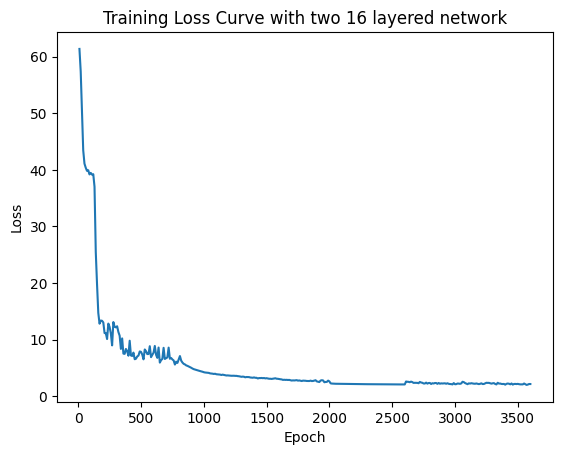

In [ ]:
import matplotlib.pyplot as plt

# File path to save the loss values
loss_file_path = "/content/drive/My Drive/ece67900/loss16.txt"

# Now you can load the loss values from the file and plot them
loaded_losses = []
with open(loss_file_path, 'r') as file:
    for line in file:
        loaded_losses.append(float(line.strip()))

epochs = range(10, len(loaded_losses)*10+10,10)  # Adjust offset as needed

# Plot the loaded loss values
plt.plot(epochs,loaded_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve with two 16 layered network')
plt.show()


In [ ]:
import torch
from torch import nn
import os
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nn_fingerprint_positioning().to(device)
if(device.type == 'cpu'):
    model.load_state_dict(torch.load("/content/drive/My Drive/ece67900/model16.pth", map_location=torch.device('cpu')))
else:
    model.load_state_dict(torch.load("/content/drive/My Drive/ece67900/model16.pth"))
print("Loaded saved model.")

# Define loss function (mean squared error for regression)
criterion = nn.MSELoss()

# List to store individual losses
individual_losses_0db = []
individual_losses_4db = []
individual_losses_8db = []

# Define the tensors for RSS values with different sigma_sf values
RSS_tp_dB_tensors = [RSS_tp_dB_0db_tensor, RSS_tp_dB_4db_tensor, RSS_tp_dB_8db_tensor]

# Iterate over the tensors and calculate losses
for RSS_tp_dB_tensor in RSS_tp_dB_tensors:
    # Move testing data to GPU if available
    RSS_tp_dB_tensor = RSS_tp_dB_tensor.to(device)
    TP_positions_tensor = TP_positions_tensor.to(device)
    individual_losses = []
    with torch.no_grad():  # No need to track gradients during testing
        running_testing_loss = 0.0
        for i in range(1000):  # Assuming 1000 test samples
            rss_values = RSS_tp_dB_tensor[i]  # Get RSS values for a single test sample
            tp_location_x = TP_positions_tensor[i].real  # Get x-coordinate
            tp_location_y = TP_positions_tensor[i].imag  # Get y-coordinate
            # Combine x and y into a tensor for loss calculation
            tp_location = torch.cat((tp_location_x.unsqueeze(0), tp_location_y.unsqueeze(0)), dim=0)
            # Forward pass
            output = model(rss_values)
            # Calculate testing loss
            testing_loss = criterion(output, tp_location)
            testing_loss = torch.sqrt(testing_loss)
            running_testing_loss += testing_loss.item()
            # Store individual loss
            individual_losses.append(testing_loss.item())

    if torch.equal(RSS_tp_dB_tensor, RSS_tp_dB_0db_tensor.to(device)):
        individual_losses_0db = individual_losses
    elif torch.equal(RSS_tp_dB_tensor, RSS_tp_dB_4db_tensor.to(device)):
        individual_losses_4db = individual_losses
    elif torch.equal(RSS_tp_dB_tensor, RSS_tp_dB_8db_tensor.to(device)):
        individual_losses_8db = individual_losses

# Calculate the average testing loss for each sigma_sf value
average_testing_loss_0db = np.mean(individual_losses_0db)
average_testing_loss_4db = np.mean(individual_losses_4db)
average_testing_loss_8db = np.mean(individual_losses_8db)

# Print the average testing loss for each sigma_sf value
print(f"Average Testing Loss for sigma_sf = 0dB: {average_testing_loss_0db:.4f}")
print(f"Average Testing Loss for sigma_sf = 4dB: {average_testing_loss_4db:.4f}")
print(f"Average Testing Loss for sigma_sf = 8dB: {average_testing_loss_8db:.4f}")

Loaded saved model.
Average Testing Loss for sigma_sf = 0dB: 4.3636
Average Testing Loss for sigma_sf = 4dB: 8.5001
Average Testing Loss for sigma_sf = 8dB: 19.6558


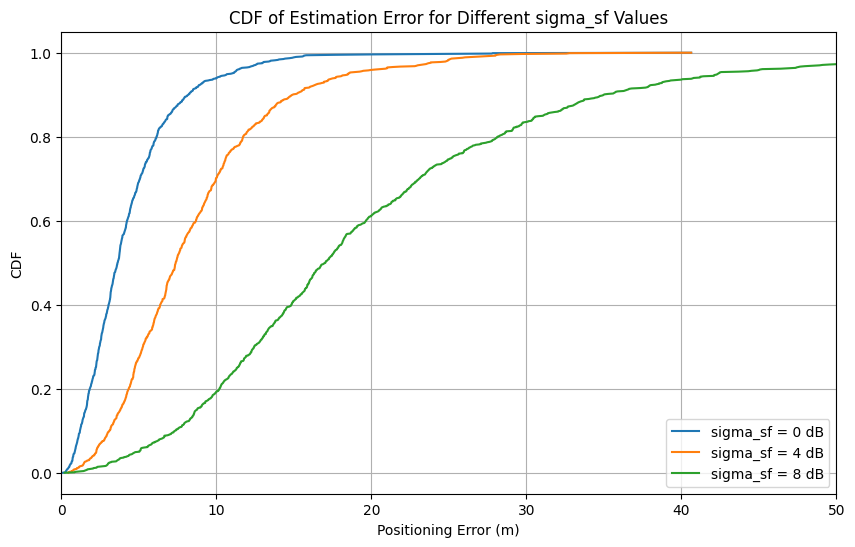

In [ ]:
# Plot CDF of losses for each sigma_sf value
plt.figure(figsize=(10, 6))
sorted_losses_0db = np.sort(individual_losses_0db)
sorted_losses_4db = np.sort(individual_losses_4db)
sorted_losses_8db = np.sort(individual_losses_8db)
yvals_0db = np.arange(len(sorted_losses_0db))/float(len(sorted_losses_0db)-1)
yvals_4db = np.arange(len(sorted_losses_4db))/float(len(sorted_losses_4db)-1)
yvals_8db = np.arange(len(sorted_losses_8db))/float(len(sorted_losses_8db)-1)
plt.plot(sorted_losses_0db, yvals_0db, label='sigma_sf = 0 dB')
plt.plot(sorted_losses_4db, yvals_4db, label='sigma_sf = 4 dB')
plt.plot(sorted_losses_8db, yvals_8db, label='sigma_sf = 8 dB')
plt.xlabel('Positioning Error (m)')
plt.ylabel('CDF')
plt.title('CDF of Estimation Error for Different sigma_sf Values')
plt.legend()
plt.grid(True)
plt.xlim(0, 50)  # Limit x-axis to 50m
plt.show()

In [ ]:
import os

# Directory where the data folders are located
data_folder = "/content/drive/MyDrive/ece67900/Geolife_Trajectories/Data"

# List to store the subfolder names containing "labels.txt"
folders_with_labels = []

# Iterate over all subfolders in the Data folder
for folder_name in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder_name)
    # Check if the subfolder contains the "labels.txt" file
    if os.path.isfile(os.path.join(folder_path, "labels.txt")):
        folders_with_labels.append(folder_name)

# Print the list of subfolder names separated by spaces
print(" ".join(folders_with_labels))


010 020 021 052 053 056 058 059 060 069 064 068 062 067 065 073 075 076 078 080 081 082 084 089 091 086 085 087 092 088 098 101 096 097 100 102 104 105 106 110 107 115 111 114 108 112 116 117 118 124 125 126 128 129 138 136 139 141 147 144 153 154 163 161 167 174 175 170 179


In [ ]:
import numpy as np
import pandas as pd
import glob
import os.path
import datetime
import os

def read_plt(plt_file):
    points = pd.read_csv(plt_file, skiprows=6, header=None,
                         parse_dates=[[5, 6]], infer_datetime_format=True)
    # for clarity rename columns
    points.rename(inplace=True, columns={'5_6': 'time', 0: 'lat', 1: 'lon'})
    # remove unused columns
    points.drop(inplace=True, columns=[2,3,4])
    return points

def apply_labels(points, labels):
    restructured_data = []
    for idx, row in labels.iterrows():
        valid_points_in_interval = points[(points['time'] >= row['start_time']) & (points['time'] <= row['end_time'])]

        if len(valid_points_in_interval) > 3:
            # Create a new DataFrame for the current path
            path_df = pd.DataFrame({
                'time': valid_points_in_interval['time'],
                'lat': valid_points_in_interval['lat'],
                'lon': valid_points_in_interval['lon']
            })

            # Add the path, label, and user to the restructured list
            restructured_data.append({
                'path': path_df,
                'label': row['label'],
            })


    # Convert the list of dictionaries to a DataFrame
    restructured_points = pd.DataFrame(restructured_data)
    return restructured_points

def read_labels(labels_file):
    labels = pd.read_csv(labels_file, skiprows=1, header=None,
                         parse_dates=[[0, 1], [2, 3]],
                         infer_datetime_format=True, delim_whitespace=True)

    # for clarity rename columns
    labels.columns = ['start_time', 'end_time', 'label']

    # replace 'label' column with integer encoding
    labels = labels[labels['label'].isin(mode_names)]
    labels['label'] = [mode_ids[i] for i in labels['label']]
    return labels

def read_all_users(folder):
    #subfolders = os.listdir(folder)
    subfolders = ['010','020',"056","064","068"]
    dfs = []
    for i, sf in enumerate(subfolders):
        subfolder_path = os.path.join(folder,sf)
        labels_file = os.path.join(subfolder_path, 'labels.txt')
        if os.path.exists(labels_file):
            labels = read_labels(labels_file)
            plt_files = glob.glob(os.path.join(subfolder_path, 'Trajectory', '*.plt'))
            df = pd.concat([read_plt(f) for f in plt_files])
            df = apply_labels(df, labels)
            df['user'] = sf
            dfs.append(df)
    return pd.concat(dfs)

In [ ]:
mode_names = ['walk', 'bike']
mode_ids = {s : i + 1 for i, s in enumerate(mode_names)}
print(mode_ids)

{'walk': 1, 'bike': 2}


In [ ]:
path_dataframe = read_all_users("/content/drive/MyDrive/ece67900/Geolife_Trajectories/Data")

<ipython-input-135-2d3557fcbf05>:42: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  labels = pd.read_csv(labels_file, skiprows=1, header=None,
<ipython-input-135-2d3557fcbf05>:9: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  points = pd.read_csv(plt_file, skiprows=6, header=None,
<ipython-input-135-2d3557fcbf05>:9: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely

In [ ]:
# Count the occurrences of each label
label_counts = path_dataframe['label'].value_counts()
print("total paths :",len(path_dataframe))

# Print the number of rows with label 1 and label 2
print("Number of rows with label 1:", label_counts.get(1, 0))
print("Number of rows with label 2:", label_counts.get(2, 0))


total paths : 1073
Number of rows with label 1: 375
Number of rows with label 2: 698


In [ ]:
for idx, row in path_dataframe.head(1).iterrows():
    print("Label:", row['label'])
    print("User:", row['user'])
    print("Path:")
    print(row['path'])
    print()

Label: 1
User: 010
Path:
                   time        lat        lon
461 2008-04-01 01:00:22  41.169583  80.262702
462 2008-04-01 01:01:22  41.169568  80.263422
463 2008-04-01 01:02:19  41.169568  80.263422
464 2008-04-01 01:02:21  41.169568  80.263422
465 2008-04-01 01:03:20  41.169175  80.263630
466 2008-04-01 01:04:21  41.168853  80.263967
467 2008-04-01 01:05:22  41.169135  80.263860
468 2008-04-01 01:06:19  41.169770  80.264252
469 2008-04-01 01:08:13  41.170472  80.264645



In [ ]:
from sklearn.model_selection import train_test_split

# Split the data for label 1
label_1_data = path_dataframe[path_dataframe['label'] == 1]
label_1_train, label_1_test = train_test_split(label_1_data, test_size=0.2, random_state=42)

# Split the data for label 2
label_2_data = path_dataframe[path_dataframe['label'] == 2]
label_2_train, label_2_test = train_test_split(label_2_data, test_size=0.2, random_state=42)

# Combine train and test sets for both labels
train_dataframe = pd.concat([label_1_train, label_2_train], ignore_index=True)
test_dataframe = pd.concat([label_1_test, label_2_test], ignore_index=True)

# Shuffle the data
train_dataframe = train_dataframe.sample(frac=1, random_state=42).reset_index(drop=True)
test_dataframe = test_dataframe.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
# Count the occurrences of each label
label_counts = train_dataframe['label'].value_counts()
print("Train set size :",len(train_dataframe))

# Print the number of rows with label 1 and label 2
print("Number of rows with label 1:", label_counts.get(1, 0))
print("Number of rows with label 2:", label_counts.get(2, 0))


Train set size : 858
Number of rows with label 1: 300
Number of rows with label 2: 558


In [ ]:
# Count the occurrences of each label
label_counts = test_dataframe['label'].value_counts()
print("Test set size: :",len(test_dataframe))

# Print the number of rows with label 1 and label 2
print("Number of rows with label 1:", label_counts.get(1, 0))
print("Number of rows with label 2:", label_counts.get(2, 0))


Test set size: : 215
Number of rows with label 1: 75
Number of rows with label 2: 140


In [ ]:
for idx, train_row in train_dataframe.head(1).iterrows():
    print("Label:", train_row['label'])
    print("User:", train_row['user'])
    print("Path:")
    print(train_row['path'])


Label: 2
User: 068
Path:
                    time        lat         lon
892  2009-04-06 07:23:11  39.982124  116.418154
893  2009-04-06 07:23:13  39.982095  116.418136
894  2009-04-06 07:23:15  39.982028  116.418141
895  2009-04-06 07:23:17  39.982006  116.418166
896  2009-04-06 07:23:19  39.981952  116.418170
...                  ...        ...         ...
2762 2009-04-06 08:47:51  39.969050  116.419904
2763 2009-04-06 08:47:53  39.969040  116.419897
2764 2009-04-06 08:47:55  39.969028  116.419888
2765 2009-04-06 08:47:57  39.969017  116.419878
2766 2009-04-06 08:47:59  39.969012  116.419873

[1875 rows x 3 columns]


In [ ]:
for idx, train_row in train_dataframe.iterrows():
    train_path = train_row['path']
    if idx == 2:  # Check if it's the 3rd row (index starts from 0)
        print("Label:", train_row['label'])
        print("User:", train_row['user'])
        print("Path:")
        print(train_row['path'])
        break  # Break the loop after printing the 3rd row

Label: 1
User: 068
Path:
                    time        lat         lon
4250 2009-07-30 10:45:44  30.546267  114.297831
4251 2009-07-30 10:45:46  30.546280  114.297840
4252 2009-07-30 10:45:48  30.546294  114.297855
4253 2009-07-30 10:45:50  30.546300  114.297854
4254 2009-07-30 10:45:52  30.546280  114.297842
...                  ...        ...         ...
5111 2009-07-30 11:27:25  30.549638  114.287613
5112 2009-07-30 11:27:27  30.549636  114.287622
5113 2009-07-30 11:27:29  30.549633  114.287631
5114 2009-07-30 11:27:31  30.549629  114.287643
5115 2009-07-30 11:27:33  30.549625  114.287650

[866 rows x 3 columns]


In [ ]:
import numpy as np
def convert_to_meters(lon_dist,lat_dist,lat_avg):
    # Conversion factors (example values, adjust as needed)
    lon_to_m = 111000
    lat_to_m = 111000

    x = lon_dist * lon_to_m
    y = lat_dist * lat_to_m * np.cos(lat_avg)
    return x, y

In [ ]:
from datetime import datetime

train_dataframe_total_rows = len(train_dataframe)
train_dataframe_half_rows = train_dataframe_total_rows // 16  # Get the index to split the DataFrame into halves

simulation_path_df = {'path_idx': [], 'path_x_coord': [], 'path_y_coord': [], 'time': []}
x0, y0 = random.randint(0, squareLength), random.randint(0, squareLength)
t0 = 0
simulation_path_df_idx = -1
# Iterate over each path in train_data
for train_dataframe_idx, train_dataframe_row in train_dataframe.iloc[:50].iterrows():
    train_path = train_dataframe_row['path']
    first_train_path = True
    new_simulation_path = True
    simulation_path_df_idx = simulation_path_df_idx+1
    for train_path_idx, train_path_row in train_path.iterrows():
        if first_train_path or new_simulation_path:
            first_train_path = False  # Set the flag to True after printing the first row
            new_simulation_path = False
            x_start = train_path_row['lon']
            y_start = train_path_row['lat']
            time_start = train_path_row['time']
            time_start_dt = time_start.to_pydatetime()
            simulation_path_df['path_idx'].append(simulation_path_df_idx)
            simulation_path_df['path_x_coord'].append(x0)
            simulation_path_df['path_y_coord'].append(y0)
            simulation_path_df['time'].append(t0)
        else:
            x_end = train_path_row['lon']
            y_end = train_path_row['lat']
            time_end = train_path_row['time']
            time_end_dt = time_end.to_pydatetime()
            lon_dist = (x_end - x_start)
            lat_dist = (y_end - y_start)
            lat_avg = 0.5*(y_end + y_start)
            x_diff,y_diff = convert_to_meters(lon_dist,lat_dist,lat_avg)
            x = x0 + x_diff
            y = y0 + y_diff

            # Check if new coordinates are within the grid
            if 0 <= x <= squareLength and 0 <= y <= squareLength:
                # Append current point to simulation_path_df
                time_diff_seconds = (time_end_dt - time_start_dt).total_seconds()
                t = t0 + (time_diff_seconds)

                simulation_path_df['path_idx'].append(simulation_path_df_idx)
                simulation_path_df['path_x_coord'].append(x)
                simulation_path_df['path_y_coord'].append(y)
                simulation_path_df['time'].append(t)

                # Update current coordinates and time
                x0, y0 = x, y
                t0 = t

                x_start, y_start = x_end,y_end
                time_start_dt = time_end_dt
            else:
                # Generate new random starting point
                x0, y0 = random.randint(0, squareLength), random.randint(0, squareLength)
                t0 = 0
                simulation_path_df_idx = simulation_path_df_idx+1
                new_simulation_path = True

simulation_path_df = pd.DataFrame(simulation_path_df)


In [ ]:
total_path_idx = simulation_path_df['path_idx'].nunique()
print("Total number of paths:", total_path_idx)
print("Total number of coordinates",len(simulation_path_df))

Total number of paths: 882
Total number of coordinates 25651


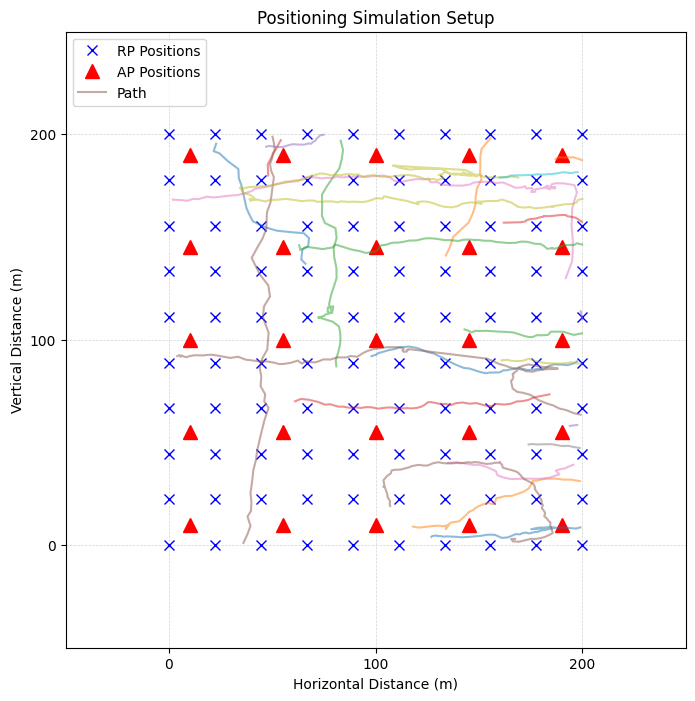

In [ ]:
import matplotlib.pyplot as plt

def plot_paths_on_layout(squareLength, RP_positions, AP_positions, paths=None):
    # Create the layout plot using function_plot_setup
    fig, ax = plt.subplots(figsize=(8, 8))
    grid_spacing = 100
    ax.set_xticks(np.arange(0, squareLength + 1, grid_spacing))
    ax.set_yticks(np.arange(0, squareLength + 1, grid_spacing))
    ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray')

    # Plot RP positions
    rp_line, = ax.plot(np.real(RP_positions), np.imag(RP_positions), 'xb', markersize=7, label='RP Positions')

    # Plot AP positions
    ap_line, = ax.plot(np.real(AP_positions), np.imag(AP_positions), '^r', markersize=10, label='AP Positions')

    ax.set_title('Positioning Simulation Setup')
    ax.set_xlabel('Horizontal Distance (m)')
    ax.set_ylabel('Vertical Distance (m)')

    # Extend the plot boundaries with padding
    padding = 50
    ax.set_xlim([-padding, squareLength + padding])
    ax.set_ylim([-padding, squareLength + padding])

    # Plot each path on the layout
    if paths is not None:
        for path_idx, path_data in paths.groupby('path_idx'):
            path_x = path_data['path_x_coord'].values
            path_y = path_data['path_y_coord'].values
            path_line, = ax.plot(path_x, path_y, alpha=0.5,label="Path")
            if path_idx == 25:
                # Store lines for legend exclusion
                legend_lines = [rp_line, ap_line,path_line]
                break

    # Show legend excluding paths
    ax.legend(handles=legend_lines, loc='upper left')
    plt.show()

# Call the function to plot paths on the layout
plot_paths_on_layout(squareLength, RP_positions, AP_positions, simulation_path_df)


In [ ]:
import numpy as np

# Define sigma_sf values
train_sigma_sf = 8

TP_positions_train = simulation_path_df['path_x_coord']+1j*simulation_path_df['path_y_coord']
TP_positions_train = np.array(TP_positions_train)

beta_fngprnt_tp_train = np.zeros((len(simulation_path_df), L))  # 25x9
for TP_train_idx in range(1, len(simulation_path_df)):
    TPDistances_train = np.abs(RP_positions[:] - TP_positions_train[TP_train_idx-1])
    newcolumn = db2pow(train_sigma_sf) ** 2 * 2 ** (-TPDistances_train / decorr)
    shadow_inv = np.linalg.inv(shadowCorrMatrix)
    term1 = newcolumn.T @ shadow_inv
    tp_meanvalues = term1 @ shadowAPrealizations
    tp_stdvalue = np.sqrt(db2pow(train_sigma_sf) ** 2 - term1 @ newcolumn)
    rss_shadowing_online = tp_meanvalues + tp_stdvalue*np.random.randn(1, L)
    for AP_idx in range(1, L + 1):
        d_2D = np.abs(TP_positions_train[TP_train_idx - 1] - AP_positions[AP_idx - 1])
        d_3D = np.sqrt((h_BS - h_UT) ** 2 + d_2D ** 2)
        PL = 35.3*np.log10(d_3D) + 22.4 + 21.3*np.log10(fc/1e9)
        beta_fngprnt_tp_train[TP_train_idx - 1, AP_idx - 1] = -PL + rss_shadowing_online[0, AP_idx - 1]

RSS_tp_mW_train = p*db2pow(beta_fngprnt_tp_train)
RSS_tp_dB_train = 10 * np.log10(RSS_tp_mW_train / 100)  # 25x9

In [ ]:
RSS_tp_dB_train_tensor = torch.tensor(RSS_tp_dB_train,dtype=torch.float32)
len(RSS_tp_dB_train_tensor)

25651

In [ ]:
# Add two new columns to store the estimated coordinates
simulation_path_df['path_x_coord_estimate'] = 0.0
simulation_path_df['path_y_coord_estimate'] = 0.0

In [ ]:
import torch
from torch import nn
import os
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nn_fingerprint_positioning().to(device)
if(device.type == 'cpu'):
    model.load_state_dict(torch.load("/content/drive/My Drive/ece67900/model16.pth", map_location=torch.device('cpu')))
else:
    model.load_state_dict(torch.load("/content/drive/My Drive/ece67900/model16.pth"))
print("Loaded saved model.")

# Move testing data to GPU if available
RSS_tp_dB_train_tensor = torch.tensor(RSS_tp_dB_train,dtype=torch.float32)
RSS_tp_dB_train_tensor = RSS_tp_dB_train_tensor.to(device)
with torch.no_grad():  # No need to track gradients during testing
    for i in range(len(RSS_tp_dB_train_tensor)):
        rss_values = RSS_tp_dB_train_tensor[i]  # Get RSS values for a single test sample
        # Forward pass
        output = model(rss_values)
        # Update the estimated coordinates in the DataFrame
        simulation_path_df.at[i, 'path_x_coord_estimate'] = output[0].item()
        simulation_path_df.at[i, 'path_y_coord_estimate'] = output[1].item()

Loaded saved model.


In [ ]:
simulation_path_df.head(50)

,path_idx,path_x_coord,path_y_coord,time,path_x_coord_estimate,path_y_coord_estimate
0,0,66.000,137.000000,0.0,69.678810,135.935333
1,0,64.002,139.103622,2.0,42.272148,159.416031
2,0,64.557,143.963443,4.0,52.149433,103.635460
3,0,67.332,145.559123,6.0,44.650154,126.647835
4,0,67.776,149.475619,8.0,78.924728,150.747253
5,0,65.223,151.868913,10.0,40.570934,161.183273
6,0,59.118,152.376570,12.0,59.796680,139.298767
7,0,52.125,153.101786,14.0,62.891182,145.778381
8,0,46.575,154.769753,16.0,29.604307,170.431625
9,0,40.581,157.670458,18.0,50.373894,164.326782


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class PathDataset_same_coordinate_estimate(Dataset):
    def __init__(self, simulation_path_df, window_size):
        self.X = []
        self.Y = []
        self.window_size = window_size
        self.path_indices = simulation_path_df['path_idx'].unique()

        for path_idx in self.path_indices:
            path_df = simulation_path_df[simulation_path_df['path_idx'] == path_idx]
            path_len = len(path_df)

            for i in range(path_len - window_size):
                x_window = path_df[['path_x_coord_estimate', 'path_y_coord_estimate']].values[i:i+window_size]
                y_sample = path_df[['path_x_coord', 'path_y_coord']].values[i+window_size]

                # Flatten the x_window and y_sample
                x_window_flat = x_window.flatten()
                y_sample_flat = y_sample.flatten()

                self.X.append(x_window_flat)
                self.Y.append(y_sample_flat)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.Y[idx])

# Define window size
window_size = 5

# Create train dataset
train_test_dataset = PathDataset_same_coordinate_estimate(simulation_path_df, window_size)

In [ ]:
print("Size of the train_test_dataset:", len(train_test_dataset))

Size of the train_test_dataset: 21577


In [ ]:
from torch.utils.data import random_split, DataLoader

# Define the size of the training and testing subsets
train_size = int(0.8 * len(train_test_dataset))
test_size = len(train_test_dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(train_test_dataset, [train_size, test_size])

# Create dataloaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [ ]:
# Print one sample from train dataloader
X_batch_train, Y_batch_train = next(iter(train_dataloader))
print("Sample from train dataloader:")
print("X_batch_train:", X_batch_train)
print("Y_batch_train:", Y_batch_train)
print()

# Print one sample from test dataloader
X_batch_test, Y_batch_test = next(iter(test_dataloader))
print("Sample from test dataloader:")
print("X_batch_test:", X_batch_test)
print("Y_batch_test:", Y_batch_test)
print()


Sample from train dataloader:
X_batch_train: tensor([[127.6889,  -6.9955,  92.3391,  18.6073, 125.0595,  44.8630, 108.0431,
           2.1885, 146.7357, -23.1623]], dtype=torch.float64)
Y_batch_train: tensor([[129.9060,  17.0370]], dtype=torch.float64)

Sample from test dataloader:
X_batch_test: tensor([[196.0651, 140.5982, 232.3475,  88.6943, 234.8496, 143.3641, 284.6145,
         146.9464, 144.2281, 158.9266]], dtype=torch.float64)
Y_batch_test: tensor([[189.5550, 150.2579]], dtype=torch.float64)



In [ ]:
import torch.nn.functional as F

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hx=None):
        if hx is None:
            batch_size = input.size(0)
            hx = torch.zeros(1, batch_size, self.hidden_size, device=input.device)
        else:
            batch_size = hx.size(1)

        # Forward pass through GRU
        gru_out, _ = self.gru(input, hx)

        out = gru_out.squeeze(1)  # Squeeze out the batch dimension

        # Forward pass through fully connected layer
        out = self.fc(out)
        return out

In [ ]:
# Define input size, hidden size, and output size
input_size = 10  # Number of features in X batch
hidden_size = 300  # Number of hidden units in GRU
output_size = 2  # Number of features in Y batch

In [ ]:
# Create GRU model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gru_model = GRUModel(input_size, hidden_size, output_size)
gru_model.to(device)

# Print model summary
print(gru_model)
# Count number of parameters in the model
total_params = sum(p.numel() for p in gru_model.parameters())
print("Total parameters in the model:", total_params)

# Train the model
# Define loss function (mean squared error for regression)
criterion = nn.MSELoss()

# Define optimizer (you can choose a different optimizer here)
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)

GRUModel(
  (gru): GRU(10, 300, batch_first=True)
  (fc): Linear(in_features=300, out_features=2, bias=True)
)
Total parameters in the model: 281402


In [ ]:
import torch
import os
import sys

# Define the training loop
def train_model(model, train_dataloader, criterion, optimizer, num_epochs, device, model_save_path, loss_file_path):
    # Check if a saved model exists
    if os.path.exists(model_save_path):
        # Load the saved model
        model.load_state_dict(torch.load(model_save_path))
        print("Loaded saved model.")

    # Move model to the device
    model.to(device)

    # Initialize list to store loss values
    losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for X_batch, Y_batch in train_dataloader:
            # Move data to the device
            X_batch, Y_batch = X_batch.to(device).float(), Y_batch.to(device).float()
            # Initialize the initial hidden state
            hx = torch.zeros(1, hidden_size).to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch, hx)

            # Calculate the loss
            loss = criterion(outputs, Y_batch)
            loss = torch.sqrt(loss)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_dataloader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}")
        sys.stdout.flush()

        # Append epoch loss to list
        losses.append(epoch_loss)

        # Save loss to file
        with open(loss_file_path, 'a') as file:
            file.write(str(epoch_loss) + '\n')

    # Save the trained model
    torch.save(model.state_dict(), model_save_path)
    print("Saved trained model.")

# Example usage:
save_model_path = "/content/drive/My Drive/ece67900/gru_300_sf8_model2.pth"
save_loss_path = "/content/drive/My Drive/ece67900/loss_gru_300_sf8_model2.txt"
num_epochs = 10
train_model(gru_model, train_dataloader, criterion, optimizer, num_epochs, device, save_model_path,save_loss_path )


Loaded saved model.
Epoch [1/10], Loss: 16.774327617253224
Epoch [2/10], Loss: 17.557306927215247
Epoch [3/10], Loss: 17.33540278801111
Epoch [4/10], Loss: 17.010665750884765
Epoch [5/10], Loss: 16.995479591829213
Epoch [6/10], Loss: 16.696070333260884
Epoch [7/10], Loss: 16.79645076641369
Epoch [8/10], Loss: 16.566193254654937
Epoch [9/10], Loss: 16.61547685125741
Epoch [10/10], Loss: 16.342876806082344
Saved trained model.


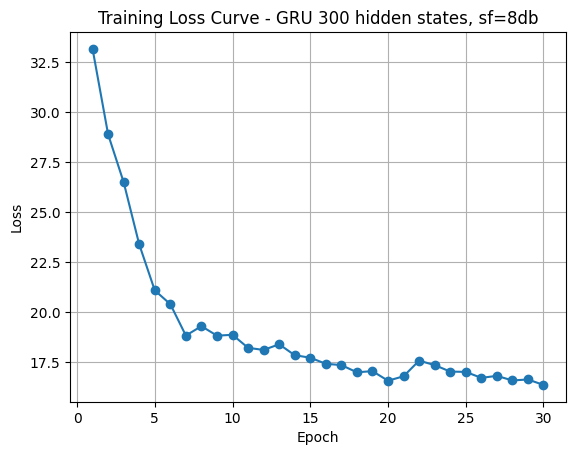

In [ ]:
import matplotlib.pyplot as plt

# Load loss values from the loss file
loss_values = []
save_loss_path = "/content/drive/My Drive/ece67900/loss_gru_300_sf8_model2.txt"
with open(save_loss_path, 'r') as file:
    for line in file:
        loss_values.append(float(line.strip()))

# Calculate the number of epochs
total_epochs = len(loss_values)

# Plot the loss curve
plt.plot(range(1, total_epochs + 1), loss_values, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve - GRU 300 hidden states, sf=8db')
plt.grid(True)
plt.show()


In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for X_batch, Y_batch in train_dataloader:
        # Move data to the device
        X_batch, Y_batch = X_batch.to(device).float(), Y_batch.to(device).float()
        # Initialize the initial hidden state
        hx = torch.zeros(1, hidden_size).to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = gru_model(X_batch, hx)

        # Calculate the loss
        loss = criterion(outputs, Y_batch)
        loss = torch.sqrt(loss)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_dataloader)}")

print('Finished Training')


Epoch [1/10], Loss: 30.09108735254291
Epoch [2/10], Loss: 17.718693288922495
Epoch [3/10], Loss: 15.407228003258004
Epoch [4/10], Loss: 13.9776327068013
Epoch [5/10], Loss: 14.09187520682661
Epoch [6/10], Loss: 13.663720101409671
Epoch [7/10], Loss: 13.296422541685713
Epoch [8/10], Loss: 13.095306836702267
Epoch [9/10], Loss: 12.792707746922645
Epoch [10/10], Loss: 13.333216507273185
Finished Training


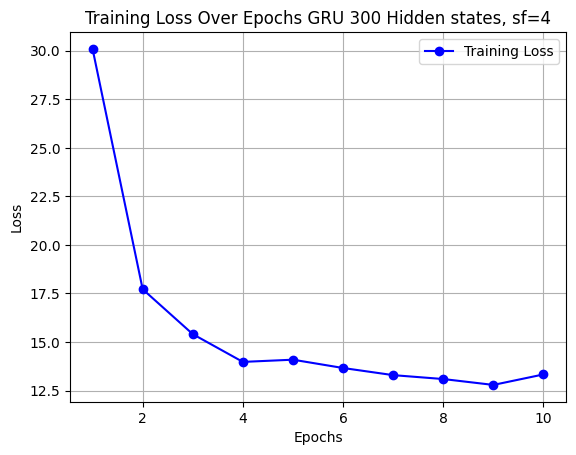

In [ ]:
import matplotlib.pyplot as plt

# Loss values
loss_values = [30.09108735254291, 17.718693288922495, 15.407228003258004, 13.9776327068013,
               14.09187520682661, 13.663720101409671, 13.296422541685713, 13.095306836702267,
               12.792707746922645, 13.333216507273185]

# Epochs
epochs = range(1, len(loss_values) + 1)

# Plotting the loss curve
plt.plot(epochs, loss_values, 'bo-', label='Training Loss')
plt.title('Training Loss Over Epochs GRU 300 Hidden states, sf=4')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
simulation_path_df

,path_idx,path_x_coord,path_y_coord,time,path_x_coord_estimate,path_y_coord_estimate
0,0,66.000,137.000000,0.0,69.678810,135.935333
1,0,64.002,139.103622,2.0,42.272148,159.416031
2,0,64.557,143.963443,4.0,52.149433,103.635460
3,0,67.332,145.559123,6.0,44.650154,126.647835
4,0,67.776,149.475619,8.0,78.924728,150.747253
...,...,...,...,...,...,...
25646,881,38.331,139.145405,26.0,23.254772,139.474579
25647,881,38.442,143.375223,28.0,59.038860,160.440323
25648,881,37.887,147.318008,30.0,-17.660316,147.987076
25649,881,33.003,149.898601,32.0,20.912718,164.134354


In [ ]:
import sys

# Load the trained GRU model from the saved model path
save_model_path = "/content/drive/My Drive/ece67900/gru_300_sf8_model2.pth"
gru_model = GRUModel(input_size, hidden_size, output_size)  # Assuming input_size, hidden_size, and output_size are defined
gru_model.load_state_dict(torch.load(save_model_path))
gru_model.to(device)  # Move model to the device
gru_model.eval()  # Set model to evaluation mode

Y_batch_ff_nn_estimate = []
total_loss_gru = 0.0
total_loss_ff_nn = 0.0
num_test_samples = 0
individual_losses_ff_nn = []
individual_losses_gru = []
for X_batch, Y_batch in test_dataloader:
    # Move data to the device
    X_batch = X_batch.to(device).float()
    Y_batch = Y_batch.to(device).float()

    # Fetch corresponding estimates from simulation_path_df
    batch_indices = Y_batch.tolist()
    path_x_coord_value = Y_batch[0][0].item()
    path_y_coord_value = Y_batch[0][1].item()

    rounded_path_x_coord = round(path_x_coord_value, 3)
    rounded_path_y_coord = round(path_y_coord_value, 3)

    rounded_simulation_path_df = simulation_path_df.copy()  # Create a copy of simulation_path_df
    rounded_simulation_path_df['rounded_path_x_coord'] = rounded_simulation_path_df['path_x_coord'].round(3)
    rounded_simulation_path_df['rounded_path_y_coord'] = rounded_simulation_path_df['path_y_coord'].round(3)

    row_with_coord_value = rounded_simulation_path_df[
        (rounded_simulation_path_df['rounded_path_x_coord'] == rounded_path_x_coord) &
        (rounded_simulation_path_df['rounded_path_y_coord'] == rounded_path_y_coord)]

    if len(row_with_coord_value) == 1:
        num_test_samples = num_test_samples + 1
        # Extract path_x_coord_estimate and path_y_coord_estimate from the DataFrame
        Y_batch_ff_nn_estimate = []
        x_estimate = row_with_coord_value['path_x_coord_estimate'].iloc[0]
        y_estimate = row_with_coord_value['path_y_coord_estimate'].iloc[0]

        # Append the estimates to Y_batch_ff_nn_estimate
        Y_batch_ff_nn_estimate.append([x_estimate, y_estimate])

        # Convert Y_batch_ff_nn_estimate to tensor
        Y_batch_ff_nn_estimate = torch.tensor(Y_batch_ff_nn_estimate)
        Y_batch_ff_nn_estimate = Y_batch_ff_nn_estimate.to(device).float()


        hx = torch.zeros(1, hidden_size).to(device)

        # Forward pass
        outputs = gru_model(X_batch, hx)

        # Calculate the loss
        loss_gru = criterion(outputs, Y_batch)
        loss_gru = torch.sqrt(loss_gru)

        # Calculate the loss
        loss_ff_nn = criterion(Y_batch_ff_nn_estimate, Y_batch)
        loss_ff_nn = torch.sqrt(loss_ff_nn)

        # Accumulate the total loss
        total_loss_gru += loss_gru.item()
        total_loss_ff_nn += loss_ff_nn.item()

        individual_losses_ff_nn.append(loss_ff_nn.item())
        individual_losses_gru.append(loss_gru.item())

# Calculate the average loss over all test samples
average_loss_gru = total_loss_gru / num_test_samples
average_loss_ff_nn = total_loss_ff_nn / num_test_samples

# Print the average loss
print(f"Average Loss with FF NN nn: {average_loss_ff_nn}")
print(f"Average Loss with GRU nn: {average_loss_gru}")


Average Loss with FF NN nn: 19.04009271508736
Average Loss with GRU nn: 16.573046315423102


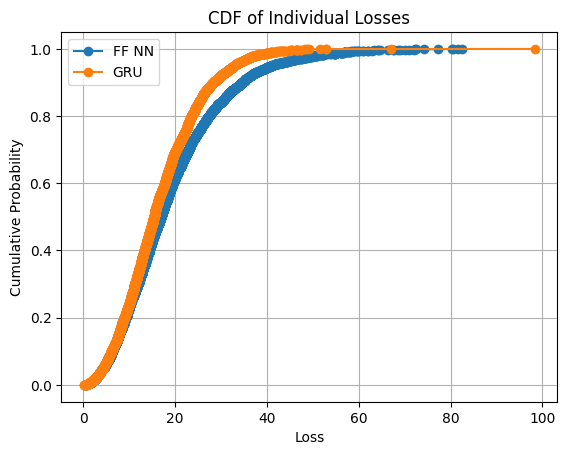

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert individual loss lists to numpy arrays
individual_losses_ff_nn = np.array(individual_losses_ff_nn)
individual_losses_gru = np.array(individual_losses_gru)

# Sort the losses
sorted_losses_ff_nn = np.sort(individual_losses_ff_nn)
sorted_losses_gru = np.sort(individual_losses_gru)

# Calculate the cumulative probabilities
cumulative_prob_ff_nn = np.arange(len(sorted_losses_ff_nn)) / float(len(sorted_losses_ff_nn))
cumulative_prob_gru = np.arange(len(sorted_losses_gru)) / float(len(sorted_losses_gru))

# Plot CDF
plt.plot(sorted_losses_ff_nn, cumulative_prob_ff_nn, label='FF NN', marker='o', linestyle='-')
plt.plot(sorted_losses_gru, cumulative_prob_gru, label='GRU', marker='o', linestyle='-')
plt.xlabel('Loss')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Individual Losses')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
simulation_path_df

,path_idx,path_x_coord,path_y_coord,time,path_x_coord_estimate,path_y_coord_estimate
0,0,66.000,137.000000,0.0,69.678810,135.935333
1,0,64.002,139.103622,2.0,42.272148,159.416031
2,0,64.557,143.963443,4.0,52.149433,103.635460
3,0,67.332,145.559123,6.0,44.650154,126.647835
4,0,67.776,149.475619,8.0,78.924728,150.747253
...,...,...,...,...,...,...
25646,881,38.331,139.145405,26.0,23.254772,139.474579
25647,881,38.442,143.375223,28.0,59.038860,160.440323
25648,881,37.887,147.318008,30.0,-17.660316,147.987076
25649,881,33.003,149.898601,32.0,20.912718,164.134354


In [ ]:
# Define input size, hidden size, and output size
input_size = 10  # Number of features in X batch
hidden_size = 500  # Number of hidden units in GRU
output_size = 2  # Number of features in Y batch

In [ ]:
# Create GRU model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gru_model_500 = GRUModel(input_size, hidden_size, output_size)
gru_model_500.to(device)

# Print model summary
print(gru_model_500)
# Count number of parameters in the model
total_params = sum(p.numel() for p in gru_model_500.parameters())
print("Total parameters in the model:", total_params)

# Train the model
# Define loss function (mean squared error for regression)
criterion = nn.MSELoss()

# Define optimizer (you can choose a different optimizer here)
optimizer = torch.optim.Adam(gru_model_500.parameters(), lr=0.001)

GRUModel(
  (gru): GRU(10, 500, batch_first=True)
  (fc): Linear(in_features=500, out_features=2, bias=True)
)
Total parameters in the model: 769002
